In [245]:
from itertools import islice

import cv2

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy.optimize import minimize, rosen, rosen_der, basinhopping, fmin, fmin_cg, differential_evolution
from scipy.spatial.distance import euclidean, cdist

from sklearn.neural_network import MLPRegressor

# mystic
from mystic.penalty import quadratic_inequality
from mystic.solvers import diffev2
from mystic.monitors import VerboseMonitor

from src.camera import Camera
from src.utils.cube import generate_cube


In [246]:
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [247]:
def draw_cube(img, points):
    points = points.astype(int)
    points = [x[0] for x in points]
    x, y = [point[0] for point in points], [point[1] for point in points]
    
    cv2.line(img, (x[0], y[0]), (x[1], y[1]), (255,255,0), 2)
    cv2.line(img, (x[1], y[1]), (x[2], y[2]), (255,255,0), 2)
    cv2.line(img, (x[2], y[2]), (x[3], y[3]), (255,255,0), 2)
    cv2.line(img, (x[3], y[3]), (x[0], y[0]), (255,255,0), 2)
    
    cv2.line(img, (x[4], y[4]), (x[5], y[5]), (255,255,0), 2)
    cv2.line(img, (x[5], y[5]), (x[6], y[6]), (255,255,0), 2)
    cv2.line(img, (x[6], y[6]), (x[7], y[7]), (255,255,0), 2)
    cv2.line(img, (x[7], y[7]), (x[4], y[4]), (255,255,0), 2)
    
    cv2.line(img, (x[0], y[0]), (x[4], y[4]), (255,255,0), 2)
    cv2.line(img, (x[1], y[1]), (x[5], y[5]), (255,255,0), 2)
    cv2.line(img, (x[2], y[2]), (x[6], y[6]), (255,255,0), 2)
    cv2.line(img, (x[3], y[3]), (x[7], y[7]), (255,255,0), 2)

    return img

In [248]:
def reprojection_distance(input, points_3d, points_2d):
    r1, r2, r3, t1, t2, t3 = input[0], input[1], input[2], input[3], input[4], input[5]
    R = cv2.Rodrigues(np.array([r1, r2, r3]))[0]
    t = np.array([[t1], [t2], [t3]])
    camera = Camera()
    projected = cv2.projectPoints(
        points_3d,
        R,
        t,
        camera.K,
        camera.distortion
    )[0]
    vec1 = projected.reshape(projected.shape[0]*2)
    vec2 = points_2d.reshape(points_2d.shape[0]*2)

    res = 0
    for v1, v2 in zip(vec1, vec2):
        res += pow(v1 - v2, 2)

    return res

In [249]:
class Frame(object):
    """ Frame object that stores all possible information needed """
    MATCHER_THREHSOLD = 0.7
    
    def __init__(self, image):
        self.image = np.copy(image)
        self.R = np.array([])
        self.t = np.array([])
        self.points_3d = np.array([])
        self.points_2d = np.array([])
        self.kp = np.array([])
        self.des = np.array([])
        
    def __str__(self):
        return "Frame:\n>> R:{}\n>> t:{}\n>> 3D:{}\n>> 2D:{}\n>> kp:{}\n>> des:{}\n".format(
            self.R.shape,
            self.t.shape,
            self.points_3d.shape,
            self.points_2d.shape,
            len(self.kp),
            len(self.des)
        )

    def create_camera_and_project(self, obj):
        camera = Camera.create(self.R, self.t)
        return camera.project(obj)
    
    def bundle_adjustment(self):
        """ Bundle adjust frame """
        R = cv2.Rodrigues(self.R)[0]
        t = self.t
        # 6 parameters for optimization
        initial = [R[0], R[1], R[2], t[0], t[1], t[2]]
        initial = [x[0] for x in initial]

#         optimized = minimize(
#             reprojection_distance,
#             initial, 
#             args=(self.points_3d, self.points_2d),
#             method='SLSQP'
#         )
        
        mon = VerboseMonitor(50)
        result = diffev2(
            reprojection_distance, 
            x0=initial, 
            args=(self.points_3d, self.points_2d),
            npop=10, 
            gtol=200,
            disp=False, 
            full_output=True, 
            itermon=mon, 
            maxiter=500
        )
        
        result = result[0] #optimized.x
        r1, r2, r3, t1, t2, t3 = result[0], result[1], result[2], result[3], result[4], result[5]

        R_optimized = cv2.Rodrigues(np.array([r1, r2, r3]))[0]
        t_optimized = np.array([[t1], [t2], [t3]])
        
        optimized_frame = Frame(self.image)
        optimized_frame.R = R_optimized
        optimized_frame.t = t_optimized
        optimized_frame.points_3d = self.points_3d
        optimized_frame.points_2d = self.points_2d
        optimized_frame.kp = self.kp
        optimized_frame.des = self.des
        
        return optimized_frame

In [250]:
class Scene(object):
    """ Scene utils """
    @classmethod
    def get_rt_from_essential(cls, pts1, pts2):
        E, mask = cv2.findEssentialMat(
            pts1, 
            pts2, 
            focal=1.0, 
            pp=(486.2, 265.59), 
            method=cv2.RANSAC, 
            prob=0.999, 
            threshold=1.0
        )

        points, R, t, mask = cv2.recoverPose(
            E, 
            pts1, 
            pts2, 
            focal=1.0,
            pp=(486.2, 265.59),
            mask=mask
        )
        
        return R, t
    
    
    @classmethod
    def recover_third_rt(cls, pts1, camera1, pts2, camera2, pts3):
        K, dist = Camera().K, Camera().distortion 
        undistorted_points_1 = cv2.undistortPoints(pts1, K, dist, R=camera1.R, P=camera1.get_projection_matrix())
        undistorted_points_2 = cv2.undistortPoints(pts2, K, dist, R=camera2.R, P=camera2.get_projection_matrix())

        points_3d_homog = cv2.triangulatePoints(
            camera1.get_projection_matrix(),
            camera2.get_projection_matrix(),
            undistorted_points_1,
            undistorted_points_2
        )
        points_3d = cv2.convertPointsFromHomogeneous(points_3d_homog.T)
        
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(points_3d, pts3, Camera().K, Camera().distortion) 
        return cv2.Rodrigues(rvecs)[0], tvecs, points_3d
    
    @classmethod
    def initial_triangulation(cls, image1, image2, image3):
        """ 1. Initial stereo camera reconstruction
            2. Third camera triangulation
        """
        sift = cv2.xfeatures2d.SIFT_create()
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        kp1, des1 = sift.detectAndCompute(image1, None)
        kp2, des2 = sift.detectAndCompute(image2, None)
        kp3, des3 = sift.detectAndCompute(image3, None)

        matches12 = flann.knnMatch(des1, des2, k=2)
        matches13 = flann.knnMatch(des1, des3, k=2)

        qidx12 = [m.queryIdx for m,n in list(filter(lambda x: x[0].distance < Frame.MATCHER_THREHSOLD*x[1].distance, matches12))]
        qidx13 = [m.queryIdx for m,n in list(filter(lambda x: x[0].distance < Frame.MATCHER_THREHSOLD*x[1].distance, matches13))]

        common_query_indexes = list(set(qidx12).intersection(qidx13))

        # match between 3 images
        good_12_matches = []
        for m, n in matches12:
            if m.queryIdx in common_query_indexes:
                good_12_matches.append(m)

        good_13_matches = []
        for m, n in matches13:
            if m.queryIdx in common_query_indexes:
                good_13_matches.append(m)

        pts1 = np.float64([kp1[m.queryIdx].pt for m in good_12_matches]).reshape(-1,1,2)
        pts2 = np.float64([kp2[m.trainIdx].pt for m in good_12_matches]).reshape(-1,1,2)
        pts3 = np.float64([kp3[m.trainIdx].pt for m in good_13_matches]).reshape(-1,1,2)
        
        R2, t2 = Scene.get_rt_from_essential(pts1, pts2)
            
        camera1 = Camera.create(np.eye(3, 3), np.zeros((3, 1)))
        camera2 = Camera.create(R2, t2)
        
        R3, t3, points_3d = Scene.recover_third_rt(camera1=camera1, camera2=camera2, pts1=pts1, pts2=pts2, pts3=pts3)

        frame1 = Frame(image1)
        frame1.R = camera1.R
        frame1.t = camera1.t
        frame1.points_3d = points_3d
        frame1.points_2d = pts1
        frame1.kp = kp1
        frame1.des = des1
        
        frame2 = Frame(image2)
        frame2.R = camera2.R
        frame2.t = camera2.t
        frame2.points_3d = points_3d
        frame2.points_2d = pts2
        frame2.kp = kp2
        frame2.des = des2
        
        frame3 = Frame(image3)
        frame3.R = R3
        frame3.t = t3
        frame3.points_3d = points_3d
        frame3.points_2d = pts3
        frame3.kp = kp3
        frame3.des = des3
        
        return frame1, frame2, frame3
    
    @classmethod
    def triangulation(cls, frame1, frame2, image3):
        """ 1. Stereo camera reconstruction
            2. Third camera triangulation
        """
        
        sift = cv2.xfeatures2d.SIFT_create()
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        kp1, des1 = sift.detectAndCompute(frame1.image, None)
        kp2, des2 = sift.detectAndCompute(frame2.image, None)
        kp3, des3 = sift.detectAndCompute(image3, None)

        matches12 = flann.knnMatch(des1, des2, k=2)
        matches13 = flann.knnMatch(des1, des3, k=2)

        qidx12 = [m.queryIdx for m,n in list(filter(lambda x: x[0].distance < Frame.MATCHER_THREHSOLD*x[1].distance, matches12))]
        qidx13 = [m.queryIdx for m,n in list(filter(lambda x: x[0].distance < Frame.MATCHER_THREHSOLD*x[1].distance, matches13))]

        common_query_indexes = list(set(qidx12).intersection(qidx13))

        # match between 3 images
        good_12_matches = []
        for m, n in matches12:
            if m.queryIdx in common_query_indexes:
                good_12_matches.append(m)

        good_13_matches = []
        for m, n in matches13:
            if m.queryIdx in common_query_indexes:
                good_13_matches.append(m)

        pts1 = np.float64([kp1[m.queryIdx].pt for m in good_12_matches]).reshape(-1,1,2)
        pts2 = np.float64([kp2[m.trainIdx].pt for m in good_12_matches]).reshape(-1,1,2)
        pts3 = np.float64([kp3[m.trainIdx].pt for m in good_13_matches]).reshape(-1,1,2)
                    
        camera1 = Camera.create(frame1.R, frame1.t)
        camera2 = Camera.create(frame2.R, frame2.t)
        
        R3, t3, points_3d = Scene.recover_third_rt(camera1=camera1, camera2=camera2, pts1=pts1, pts2=pts2, pts3=pts3)
        
        frame3 = Frame(image3)
        frame3.R = R3
        frame3.t = t3
        frame3.points_3d = points_3d
        frame3.points_2d = pts3
        frame3.kp = kp3
        frame3.des = des3
        
        return frame1, frame2, frame3

In [251]:
class Timeline(object):
    """ Main class that stores video """
    RESIZE_SCALE = 2
    KEYFRAME_DISTANCE = 30
    
    def __init__(self, path="../videos/video13.mp4"):
        self.path_video = path # path to video
        self.buffer = [] # buffered video a.k.a images
        self.K = Camera().K # calibration matrix
        self.distortion = Camera().distortion # distortion coefs
        self.common_points = [] # common points between keyframes    
        
        self.__read_into_buffer()
        self.keyframes_indexes = [x for x in range(0, len(self.buffer), self.KEYFRAME_DISTANCE)]
        
        self.keyframes = []
        self.adjusted_keyframes = []
        self.__recover_keyframes()
        self.__adjust_keyframes()
        
        
    def __resize(self, frame):
        """ Resize video in hald """
        height, width, layers =  frame.shape
        frame = cv2.resize(frame, (int(width/2), int(height/2)))
        return frame
        
    def __read_into_buffer(self):
        """ Reads video into object buffer """
        cap = cv2.VideoCapture(self.path_video)
        buffer = []
        original_images_buffer = []
        while(cap.isOpened()):
            ret, frame = cap.read()    
            if ret == True:
                frame = self.__resize(frame)
                buffer.append(frame)
                original_images_buffer.append(frame)
            else:
                cap.release()
                
        self.buffer = buffer
                
    def __recover_keyframes(self):
        """  """
        keyframes = []
        
        frame1, frame2, frame3 = None, None, None
        
        for i, triple in enumerate(window(self.keyframes_indexes, 3)):
            image1, image2, image3 = self.buffer[triple[0]], self.buffer[triple[1]], self.buffer[triple[2]]
            if i > 0:
                frame1, frame2, frame3 = Scene.triangulation(frame2, frame3, image3)
                keyframes.append(frame3)
            else: # if initial
                frame1, frame2, frame3 = Scene.initial_triangulation(image1, image2, image3)
                keyframes = [frame1, frame2, frame3]
                
        self.keyframes = keyframes
                
    def __adjust_keyframes(self):
        self.adjusted_keyframes = [frame.bundle_adjustment() for frame in self.keyframes]
        
    
    def interpolate_frames_and_save(self):
        cube = generate_cube(1.0, [0,0,10])
        train = []
        for kf in self.adjusted_keyframes[:]:
            object_points = []
            for point in kf.create_camera_and_project(cube):
                x, y = point[0]
                object_points.append(x)
                object_points.append(y)

            train.append(object_points)

        df = pd.DataFrame(train)
        
        X = np.array([x*self.KEYFRAME_DISTANCE for x in range(df.shape[0])]).reshape(df.shape[0], 1)
        y = df
        
        mlp = MLPRegressor(
            max_iter=2000,
            learning_rate_init=0.01,
            random_state=42
        )
        mlp.fit(X, y)
        
        for i, image in enumerate(self.buffer):
            frame = Frame(image)
            res = mlp.predict(i)
            image = draw_cube(frame.image, res.reshape((-1, 1, 2)))

            cv2.imwrite("../saved_images/{}.png".format("%03d" % i), image)
            
        
        

In [252]:
timeline = Timeline()

Generation 0 has Chi-Squared: 8241.189328
Generation 50 has Chi-Squared: 1303.905406
Generation 100 has Chi-Squared: 1073.778238
Generation 150 has Chi-Squared: 1068.869006
Generation 200 has Chi-Squared: 1065.843027
Generation 250 has Chi-Squared: 1062.583123
Generation 300 has Chi-Squared: 1062.161260
Generation 350 has Chi-Squared: 1062.091347
Generation 400 has Chi-Squared: 1062.044140
Generation 450 has Chi-Squared: 1061.788770
Generation 500 has Chi-Squared: 1061.116821
STOP("EvaluationLimits with {'evaluations': 60000, 'generations': 500}")
Generation 0 has Chi-Squared: 38088.679359
Generation 50 has Chi-Squared: 4422.937484
Generation 100 has Chi-Squared: 4252.704574
Generation 150 has Chi-Squared: 4209.467493
Generation 200 has Chi-Squared: 1839.501280
Generation 250 has Chi-Squared: 1839.501276
Generation 300 has Chi-Squared: 1839.501276
Generation 350 has Chi-Squared: 1839.501276
STOP("ChangeOverGeneration with {'tolerance': 0.005, 'generations': 200}")
Generation 0 has Chi-

In [253]:
timeline.interpolate_frames_and_save()

In [169]:
from src.utils.cube import generate_cube
cube = generate_cube(1.0, [0,0,10])

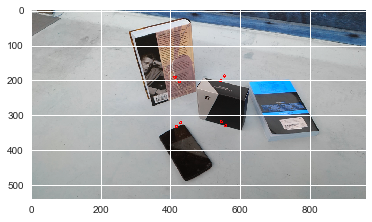

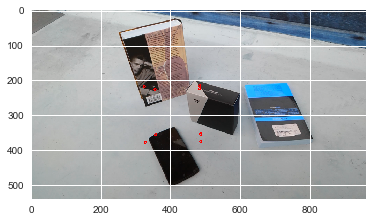

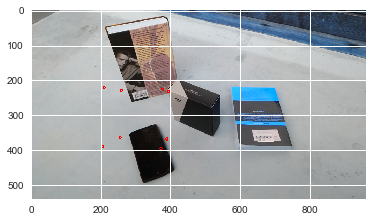

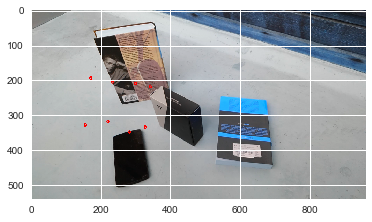

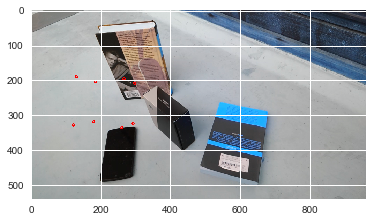

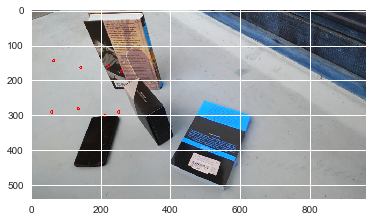

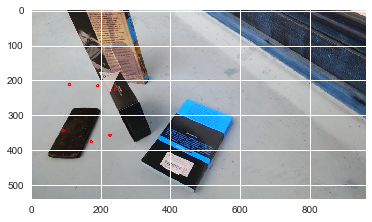

In [170]:
for kf in timeline.adjusted_keyframes[:]:
    image = draw_cube(kf.image, kf.create_camera_and_project(cube))
    for point in kf.create_camera_and_project(cube):
        try:
            x, y = point[0]
            cv2.circle(kf.image, (int(x), int(y)), 3, (255, 0, 0), thickness=2, lineType=8, shift=0)
        except Exception as e:
            print(e)
        
    plt.imshow(kf.image)
    plt.show()

In [171]:
from sklearn.neural_network import MLPRegressor

In [172]:
train = []
for kf in timeline.adjusted_keyframes[:]:
    object_points = []
    for point in kf.create_camera_and_project(cube):
        x, y = point[0]
        object_points.append(x)
        object_points.append(y)
        
    train.append(object_points)

df = pd.DataFrame(train)

In [173]:
X = np.array([x*30 for x in range(df.shape[0])]).reshape(df.shape[0], 1)
y = df

In [174]:
mlp = MLPRegressor(
    max_iter=2000,
    learning_rate_init=0.01,
    random_state=42
)
mlp.fit(X, y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [175]:
for i, image in enumerate(timeline.buffer):
    frame = Frame(image)
    res = mlp.predict(i)
    for point in res.reshape((-1, 1, 2)):
        try:
            x, y = point[0]
            cv2.circle(frame.image, (int(x), int(y)), 3, (255, 0, 0), thickness=2, lineType=8, shift=0)
        except Exception as e:
            print(e)
        
    cv2.imwrite("saved_images/{}.png".format("%03d" % i), frame.image)
#     print("saved_images/{}.png".format("%03d" % i))
#     plt.imshow(frame.image)
#     plt.show()
#     break
    

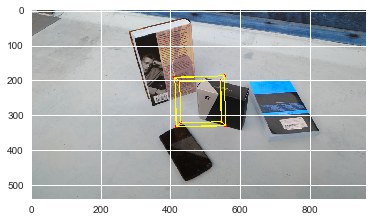

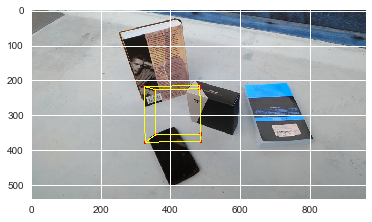

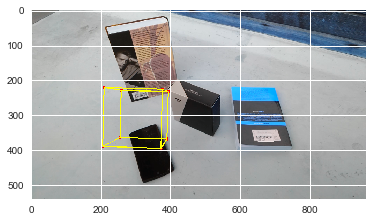

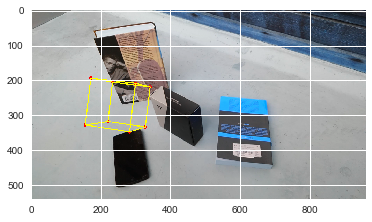

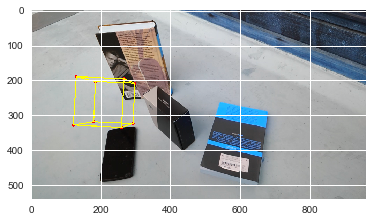

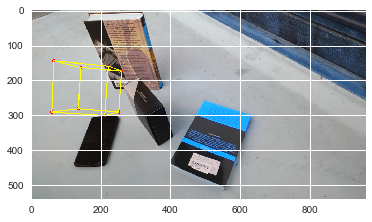

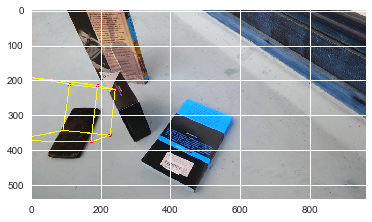

In [216]:
for kf in timeline.adjusted_keyframes[:]:
    image = draw_cube(kf.image, kf.create_camera_and_project(cube))
    plt.imshow(image)
    plt.show()

In [225]:
for i, image in enumerate(timeline.buffer):
    frame = Frame(image)
    res = mlp.predict(i)
    image = draw_cube(frame.image, res.reshape((-1, 1, 2)))
    
    cv2.imwrite("saved_images/{}.png".format("%03d" % i), image)